# Treino do zero (*from scratch*)

Neste script vamos conhecer a estratégia de treino tradicional de redes neurais em geral: **O treino do zero (*from scratch*)**. <br>
Trataremos do uso mais tradicional de CNNs: **classificação de imagens**.


Primeiro de tudo, vamos fazer os imports.

In [1]:
# Identifica a seção sobre determinismo e fixação de sementes para reprodutibilidade.
# >>> Determinismo / Sementes

# Importa módulos do SO e gerador pseudoaleatório padrão do Python.
import os, random

# Importa NumPy para controle de aleatoriedade em operações numéricas.
import numpy as np

# Importa utilitário de cópia profunda e o PyTorch.
import copy, torch

# Define um valor de semente único a ser usado por todas as bibliotecas.
SEED = 42

# Fixa a semente do gerador aleatório do Python (random).
random.seed(SEED)

# Fixa a semente do NumPy.
np.random.seed(SEED)

# Fixa a semente do PyTorch na CPU.
torch.manual_seed(SEED)

# Fixa a semente do PyTorch em todas as GPUs disponíveis (CUDA).
torch.cuda.manual_seed_all(SEED)

# Observação ao leitor: os ajustes abaixo podem aumentar a reprodutibilidade mas afetar desempenho.
# Para resultados mais reprodutíveis (pode reduzir performance em GPU)

# Controla o uso de algoritmos determinísticos no PyTorch; False = pode usar kernels mais rápidos porém não determinísticos.
torch.use_deterministic_algorithms(False)  # deixe True se quiser máximo determinismo

# Habilita o autotuner do cuDNN para escolher a implementação mais rápida (pode introduzir não determinismo).
torch.backends.cudnn.benchmark = True

In [2]:
# Implementação e treinamento da rede

# Importa a API funcional do torch.nn (útil para perdas/ativ. funcionais caso necessário).
from torch.nn import functional as F

# Traz os submódulos de redes neurais (nn) e otimizadores (optim).
from torch import nn, optim
# Agendadores de taxa de aprendizado.
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Carregamento de Dados

# Utilitário para criar DataLoaders (mini-batches, shuffle, workers paralelos).
from torch.utils.data import DataLoader

# Datasets prontos (CIFAR-10, MNIST, etc.) do torchvision.
from torchvision import datasets

# Transforms para pré-processamento/augmentação (ToTensor, Normalize, Resize, ...).
from torchvision import transforms

# Seção de organização do script: métricas e visualização.
# Plots e análises

# Métrica de acurácia do scikit-learn.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Biblioteca de gráficos.
import matplotlib.pyplot as plt

# Visualização de matrizes em formato de heatmap.
import seaborn as sns

# Operações numéricas e arrays.
import numpy as np

# Medição de tempo e utilidades do SO (paths, variáveis de ambiente, etc.).
import time, os

# (Apenas em Jupyter) Renderiza gráficos do Matplotlib embutidos nas células.
%matplotlib inline


In [3]:
# Define os hiperparâmetros do treinamento em um dicionário.
args = {
    # Número total de épocas (passagens completas pelo dataset).
    'epoch_num': 150,     # Número de épocas.
    # Taxa de aprendizado inicial do otimizador.
    'lr': 1e-3,           # Taxa de aprendizado.
    # Penalidade L2 aplicada aos pesos para reduzir overfitting.
    #    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    #    'weight_decay': 5e-3, # Penalidade L2 (Regularização).
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    # Quantidade de amostras processadas por iteração.
    'batch_size': 50,     # Tamanho do batch.
    'eta_min': 3e-5,
}

# Verifica se há GPU CUDA disponível para acelerar o treinamento.
# Definindo dispositivo de hardware
# if torch.cuda.is_available():
#     # Se houver CUDA, usa a GPU.
#     args['device'] = torch.device('cuda')
# else:
#     # Caso contrário, recorre à CPU.
#     args['device'] = torch.device('cpu')

args['device'] = torch.device('cpu')

# Mostra no console qual dispositivo foi selecionado.
print(args['device'])

# Intra-op = kernels (convoluções etc.), Inter-op = paralelismo entre ops
torch.set_num_threads(8)           # ~ núcleos físicos (8)
torch.set_num_interop_threads(1)   # inter-op baixo ajuda na CPU

# oneDNN (mkldnn) costuma acelerar no CPU; já é True por padrão.
torch.backends.mkldnn.enabled = True

cpu


## Carregamento de Dados

Usaremos o dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), um conjunto de imagens RGB divididas em 10 categorias de objeto: avião, automóvel, pássaro, gato, veado, cachorro, sapo, cavalo, navio, caminhão. As imagens possuem $32 \times 32$ pixels.

Trata-se de um dataset de 60 mil imagens naturais (do mundo real), muito utilizado para avaliar a qualidade de modelos de aprendizado profundo.

https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

In [4]:
# Pipeline de transformações para TREINO e TESTE.
# Importa utilitários de pré-processamento/augmentação de imagens do torchvision.
from torchvision import transforms

# Médias por canal (R, G, B) do CIFAR-10 para normalização.
MEAN = (0.4914, 0.4822, 0.4465)

# Desvios-padrão por canal (R, G, B) do CIFAR-10 para normalização.
STD  = (0.2023, 0.1994, 0.2010)

# Pipeline de transformações para TREINO: inclui aumentos de dados + normalização.
train_transform = transforms.Compose([
    # Crop aleatório 32×32 com padding=2; bordas preenchidas por reflexão (reduz overfitting).
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    # Flip horizontal aleatório com probabilidade de 40% (aumenta variação espacial).
    transforms.RandomHorizontalFlip(p=0.4),
    # Converte PIL/NumPy para Tensor (C×H×W) com valores em [0,1].
    transforms.ToTensor(),
    # Normaliza cada canal usando as estatísticas definidas acima (acelera/estabiliza o treino).
    transforms.Normalize(MEAN, STD),
])

# Pipeline de transformações para TESTE: apenas conversão + normalização (sem augmentações).
test_transform = transforms.Compose([
    # Converte para Tensor mantendo a imagem intacta (sem aleatoriedade).
    transforms.ToTensor(),
    # Aplica a mesma normalização do treino para consistência.
    transforms.Normalize(MEAN, STD),
])

# Instancia o dataset CIFAR-10 para TREINO no diretório atual.
train_set = datasets.CIFAR10('.', 
# Seleciona o split de treino.
                      train=True, 
# Aplica o pipeline de transformações com aumento de dados.
                      transform=train_transform, 
# Faz o download se os arquivos não existirem localmente; fecha a chamada.
                      download=True)

# Instancia o dataset CIFAR-10 para TESTE no diretório atual.
test_set = datasets.CIFAR10('.', 
# Seleciona o split de teste.
                      train=False, 
# Usa o pipeline determinístico (sem augmentations) para avaliação.
                      transform=test_transform, 
# Não força novo download (assume que já foi feito no train).
                      download=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.5976489].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.351526..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7692488..2.3440151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3395875..1.6611518].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808.

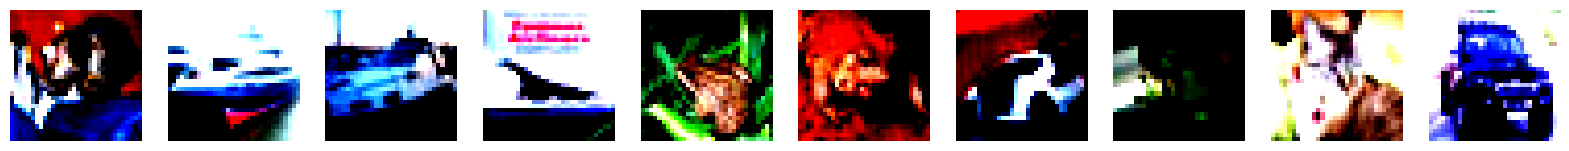

In [5]:
# Cria uma figura com 1 linha e 10 subplots; o tamanho total é 20×2 polegadas.
fig, axs = plt.subplots(1,10, figsize=(20, 2))

# Itera sobre as 10 primeiras amostras do conjunto de teste.
for i in range(10):
  # Obtém a imagem (tensor) e o rótulo correspondente no índice i.
  data, label = test_set[i]
  # Converte de C×H×W para H×W×C para exibir corretamente com o Matplotlib.
  axs[i].imshow(data.permute((1,2,0)))
  # Remove os eixos para uma visualização limpa.
  axs[i].axis('off')


In [6]:
g = torch.Generator().manual_seed(SEED)

# Define uma função de inicialização por worker do DataLoader (executada em cada processo de leitura).
def _worker_init_fn(worker_id):
    # Garante que cada worker não use múltiplas threads BLAS (evita competir com o treino).
    # Garantir que cada worker não roube threads do treino
    rs = SEED + worker_id
    random.seed(rs); np.random.seed(rs); torch.manual_seed(rs)
    # Limita threads do OpenMP usadas por libs como NumPy/SciPy.
    os.environ["OMP_NUM_THREADS"] = "1"
    # Limita threads do backend MKL.
    os.environ["MKL_NUM_THREADS"] = "1"
    # Limita threads do OpenBLAS.
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    # Tenta também forçar o PyTorch no worker a usar 1 thread para computação intra/inter-op.
    try:
        # Define 1 thread para operações internas (intra-op).
        torch.set_num_threads(1)        # por segurança também no worker
        # Define 1 thread para paralelismo entre operações (inter-op).
        torch.set_num_interop_threads(1)
    # Se a API não existir no ambiente, apenas segue em frente.
    except Exception:
        pass



# Número de processos de leitura para o loader de treino.
NUM_WORKERS_TRAIN = 8
# Número de processos de leitura para o loader de teste/validação (geralmente menor).
NUM_WORKERS_TEST  = 4

# Cria o DataLoader de TREINO com configurações de performance para CPU.
train_loader = DataLoader(
    # Dataset de treino previamente instanciado.
    train_set,
    # Tamanho do mini-batch; no CPU é comum testar 64 ou 128 (aqui vem de args).
    batch_size=args['batch_size'],   # sugiro testar 64 e 128 no CPU; comece por 64
    # Embaralha amostras a cada época (boa prática no treino).
    shuffle=True,
    # Quantidade de processos workers para carregar dados em paralelo.
    num_workers=NUM_WORKERS_TRAIN,
    # No CPU, deixar False (pinning ajuda apenas para transferir para GPU).
    pin_memory=False,                # CPU: False
    # Mantém os workers vivos entre épocas (reduz overhead de criação).
    persistent_workers=True,
    # Nº de lotes pré-carregados por worker (prefetch) para alimentar a fila.
    prefetch_factor=2,
    # ???? Descarta o último lote se ele for menor que batch_size (estabiliza shapes).
    drop_last=False,
    # Função de init para cada worker (limita threads internas).
    worker_init_fn=_worker_init_fn,
    generator=g,
)

# Cria o DataLoader de TESTE/validação (sem embaralhar e com menos workers).
test_loader = DataLoader(
    # Dataset de teste previamente instanciado.
    test_set,
    # Mesmo tamanho de lote do treino (pode aumentar se couber na RAM).
    batch_size=args['batch_size'],
    # Em avaliação normalmente mantemos a ordem fixa.
    shuffle=False,
    # Menos workers costumam ser suficientes no teste.
    num_workers=NUM_WORKERS_TEST,
    # No CPU, pin_memory desnecessário.
    pin_memory=False,
    # Mantém os workers entre iterações para reduzir overhead.
    persistent_workers=True,
    # Prefetch de 2 lotes por worker para suavizar leitura.
    prefetch_factor=2,
    # Mesma função de init para controlar threads nos workers.
    worker_init_fn=_worker_init_fn,
    generator=g,
)


## LeNet 5

Primeiro de tudo, precisamos **implementar uma CNN**. Sim, chegou a hora de colocar em prática tudo que já sabemos sobre redes convolucionais, montando uma arquitetura completa!

A arquitetura escolhida para essa aula é a LeNet. Ela é a primeira CNN bem sucedida da história, [proposta em 1998 pelo Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). 

<img src="Lenet1.png" width="800">

<img src="Lenet2.jpeg" width="700">

Vamos implementar blocos convolucionais incluindo todas as camadas que aprendemos nesse curso:
```python
net = nn.Sequential(
          nn.Conv2d(...),
          nn.BatchNorm2d(...),
          nn.Tanh(), # Ativação específica da LeNet
          nn.AvgPool2d(...), # Pooling específico da LeNet
      )
```

In [7]:
# Define a rede no estilo LeNet-5 usando um contêiner sequencial.
net = nn.Sequential(
# Bloco conv 1: 3 canais → 6 mapas, kernel 5, sem padding (32→28).
        nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),        # entrada: (b, 3, 32, 32) e saida: (b, 6, 28, 28)
# Normaliza por canal (estabiliza treinamento).
        nn.BatchNorm2d(6),
# Ativação Tanh (seguindo o LeNet original).
        nn.Tanh(),
# Pooling médio 2×2 (reduz 28→14 em H e W).
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 6, 28, 28) e saida: (b, 6, 14, 14)
        
# Bloco conv 2: 6→16 mapas, kernel 5, sem padding (14→10).
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),       # entrada: (b, 6, 14, 14) e saida: (b, 16, 10, 10)
# BN para os 16 canais.
        nn.BatchNorm2d(16),
# Ativação Tanh.
        nn.Tanh(),
# Pooling médio 2×2 (10→5).
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 16, 10, 10) e saida: (b, 16, 5, 5)
        
# Bloco conv 3: 16→120 mapas, kernel 5 cobrindo todo o 5×5 (5→1).
        nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),     # entrada: (b, 16, 5, 5) e saida: (b, 120, 1, 1)
# BN para 120 canais.
        nn.BatchNorm2d(120),
# Ativação Tanh.
        nn.Tanh(),
# Achata o tensor (b,120,1,1) → (b,120).
        nn.Flatten(),  # lineariza formando um vetor                # entrada: (b, 120, 1, 1) e saida: (b, 120*1*1) = (b, 120)
        
# Camada totalmente conectada: 120→84.
        nn.Linear(120, 84),                                         # entrada: (b, 120) e saida: (b, 84)
# Tanh novamente (padrão LeNet).
        nn.Tanh(),
# Camada de saída: 84→10 classes (CIFAR-10).
        nn.Linear(84, 10),                                          # entrada: (b, 84) e saida: (b, 10)
        )

# Move o modelo para o dispositivo configurado (GPU se disponível, senão CPU).
net = net.to(args['device'])

print(net)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)


VGG16

In [8]:
# # Definindo a rede
# net = nn.Sequential(
#         ## ConvBlock 1
#         nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),      # entrada: (b, 3, 224, 224) e saida: (b, 64, 224, 224)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 64, 224, 224) e saida: (b, 64, 112, 112)
        
#         ## ConvBlock 2
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # entrada: (b, 64, 112, 112) e saida: (b, 128, 112, 112)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 128, 112, 112) e saida: (b, 128, 56, 56)
        
#         ## ConvBlock 3
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 128, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 256, 56, 56) e saida: (b, 256, 28, 28)
        
#         ## ConvBlock 4
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 28, 28) e saida: (b, 512, 14, 14)
        
#         ## ConvBlock 4
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 14, 14) e saida: (b, 512, 7, 7)
#         nn.Flatten(),  # lineariza formando um vetor               # entrada: (b, 512, 7, 7) e saida: (b, 512*7*7) = (b, 25088)
 
#         ## DenseBlock
#         nn.Linear(25088, 4096),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 4096),                                     # entrada: (b, 4096) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 10),                                       # entrada: (b, 4096) e saida: (b, 10)
#         nn.Softmax(dim=-1)
#         )

# # Subindo no hardware de GPU (se disponível)
# net = net.to(args['device'])

# Estratégias de Treino

## Do zero (From scratch)

O primeiro passo do treinamento do zero é definir os algoritmos que serão utilizados no processo de treinamento. Eles são:

* **Função de perda**, que vai avaliar a qualidade da performance da rede a cada passo de treinamento;
* **Otimizador**, que a partir da função de perda vai definir a melhor forma de atualizar os pesos.

In [9]:
# >>> Hiperparâmetros e otimizador/scheduler (override recomendado)

# Define a função de perda de entropia cruzada (adequada para classificação multi-classe) e move-a para o device (CPU/GPU).
# Loss com label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.05).to(args['device'])

# Cria o otimizador Adam para todos os parâmetros da rede, usando a taxa de aprendizado e o weight decay definidos em args.

try:
    optimizer = optim.Adam(
        net.parameters(),
        lr=args['lr'],
        weight_decay=args['weight_decay']
    )
    print(f"Optimizer: {optimizer}")
except NameError as e:
    print("Atenção: modelo 'net' ainda não definido ao rodar esta célula. Execute após criar o modelo.")
    
# Scheduler (Cosine Annealing). Usa args['epoch_num'] se existir, senão T_max=80.
TMAX = None
try:
    TMAX = int(args.get('epoch_num', 150))
except Exception:
    TMAX = 150

# Controla a redução da taxa de aprendizado quando a perda de validação estagna.
try:
    scheduler = CosineAnnealingLR(optimizer, T_max=TMAX, eta_min=args['eta_min'] )
    print(f"Scheduler: CosineAnnealingLR(T_max={TMAX}, eta_min={args['eta_min']})")
except Exception as e:
    print("Falha ao criar scheduler Cosine. Mantenha o atual ou crie após definir optimizer/net.", e)


Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0005
)
Scheduler: CosineAnnealingLR(T_max=150, eta_min=3e-05)


In [10]:
# Seção que prepara o uso de EMA (Exponential Moving Average) dos pesos do modelo.
# >>> EMA (Exponential Moving Average) dos pesos

# Flag para habilitar/desabilitar EMA durante o treino/validação.
use_ema = True
# Fator de decaimento da EMA (quanto mais próximo de 1, mais lenta a atualização).
ema_decay = 0.999

# Tenta criar uma cópia do modelo para manter os pesos suavizados por EMA.
try:
    # Copia profunda do modelo 'net' e move a cópia para o mesmo device (CPU/GPU).
    ema_net = copy.deepcopy(net).to(args['device'])
    # Desabilita o cálculo de gradiente para todos os parâmetros da cópia (EMA é só para acumular pesos).
    for p in ema_net.parameters():
        # Garante que a rede EMA não será atualizada por backprop.
        p.requires_grad = False
    # Mensagem de sucesso ao preparar a estrutura da EMA.
    print("EMA pronta (decay=0.999).")
# Caso 'net' não exista ou ocorra algum erro ao copiar/mover, informa o usuário.
except Exception as e:
    # Orienta a criar/instanciar 'net' antes de configurar a EMA e mostra a exceção.
    print("Crie o modelo 'net' antes de executar a EMA:", e)


EMA pronta (decay=0.999).


In [11]:
# Cabeçalho da seção: funções utilitárias para medir perda média e acurácia em um loader.

# Define uma função que calcula (loss média, acurácia %) de um modelo em um DataLoader.
def eval_loss_acc(model, loader, criterion, device):
    # Coloca o modelo em modo de avaliação (desativa Dropout e usa BN com estatísticas fixas).
    model.eval()
    # Acumuladores: lista de perdas (para média) e buffers de rótulos/previsões.
    losses = []
    y_true, y_pred = [], []
    # Desativa gradientes para acelerar a inferência e economizar memória.
    with torch.no_grad():
        # Itera por todos os lotes do loader (x = imagens, y = rótulos).
        for x, y in loader:
            # Move dados para o dispositivo (CPU/GPU) informado.
            x = x.to(device)
            y = y.to(device)
            # Forward: obtém logits (pontuações por classe) do modelo.
            logits = model(x)
            # Calcula a perda do lote com o critério fornecido (ex.: CrossEntropyLoss).
            loss = criterion(logits, y)
            # Guarda o valor escalar da perda (item()) para média posterior.
            losses.append(loss.item())
            # Converte logits em classes previstas (índice do maior logit).
            preds = logits.argmax(dim=1)
            # Armazena rótulos e predições no CPU (como tensores; serão concatenados depois).
            y_true.append(y.cpu())
            y_pred.append(preds.cpu())
    # Importa torch localmente com alias para evitar sombra do 'torch' externo (opcional).
    import torch as _torch
    # Concatena todos os rótulos e converte para NumPy.
    y_true = _torch.cat(y_true).numpy()
    # Concatena todas as predições e converte para NumPy.
    y_pred = _torch.cat(y_pred).numpy()
    # Calcula a acurácia em % (accuracy_score espera y_true primeiro e y_pred depois).
    acc = accuracy_score(y_true, y_pred) * 100.0
    # Retorna a perda média (usando np.mean; pressupõe 'import numpy as np' já feito) e a acurácia como float.
    return float(np.mean(losses)), float(acc)


Relembrando o passo a passo do fluxo de treinamento:

* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Zerar o gradiente do otimizador
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [12]:
# Define a função de treinamento que executa uma época completa sobre o DataLoader de treino.
def train(train_loader, net, epoch):

  # Coloca o modelo em modo de treino (Dropout/BN em modo training).
  net.train()
  # Marca o início para medir o tempo da época.
  start = time.time()

  # Acumuladores para perda média da época e métricas.
  epoch_loss  = []
  # Buffers para previsões e rótulos (para calcular acurácia por época).
  pred_list, rotulo_list = [], []

  # Itera com índice para permitir o bootstrap do EMA no 1º batch.
  for batch_idx, (dado, rotulo) in enumerate(train_loader):
    # Move o batch de imagens para o device (CPU/GPU).
    dado   = dado.to(args['device'])
    # Move os rótulos para o device.
    rotulo = rotulo.to(args['device'])

    # Forward: obtém logits do modelo.
    ypred = net(dado)
    # Calcula a perda (CrossEntropy) do lote.
    loss  = criterion(ypred, rotulo)
    # Guarda o valor escalar da loss do lote (sem grad) para média posterior.
    epoch_loss.append(loss.detach().cpu().item())

    # Predição pontual do lote (classe = argmax dos logits).
    pred = ypred.argmax(dim=1)
    # Acumula as predições no CPU como NumPy.
    pred_list.append(pred.detach().cpu().numpy())
    # Acumula os rótulos verdadeiros no CPU como NumPy.
    rotulo_list.append(rotulo.detach().cpu().numpy())

    # Zera gradientes acumulados (usa set_to_none para eficiência).
    optimizer.zero_grad(set_to_none=True)
    # Backward: calcula gradientes da loss.
    loss.backward()
    # Atualiza os parâmetros conforme o otimizador.
    optimizer.step()

    # ===== Atualização EMA por mini-batch (se habilitada) =====
    if 'ema_net' in globals() and use_ema:
      # Desabilita gradientes na atualização EMA.
      with torch.no_grad():
        # No 1º batch do 1º epoch, sincroniza a ema_net com a net (bootstrap).
        if epoch == 0 and batch_idx == 0:
          ema_net.load_state_dict(net.state_dict())

        # 1) Atualiza parâmetros: p_ema = decay*p_ema + (1-decay)*p_src
        for p_src, p_ema in zip(net.parameters(), ema_net.parameters()):
          p_ema.data.mul_(ema_decay).add_(p_src.data, alpha=1 - ema_decay)

        # 2) Copia buffers (ex.: estatísticas do BatchNorm) diretamente.
        for b_src, b_ema in zip(net.buffers(), ema_net.buffers()):
          b_ema.data.copy_(b_src.data)
    # ==========================================================

  # Concatena e achata predições de todos os lotes.
  pred_list    = np.asarray(pred_list).ravel()
  # Concatena e achata rótulos de todos os lotes.
  rotulo_list  = np.asarray(rotulo_list).ravel()
  # Calcula acurácia da época (y_true primeiro, y_pred depois).
  acc = accuracy_score(rotulo_list, pred_list)

  # Marca o fim para medir a duração da época.
  end = time.time()
  # Cabeçalho de log de treino.
  print('#################### Train ####################')
  # Imprime loss média, desvio padrão, acurácia (%) e tempo da época.
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' %
        (epoch, np.mean(epoch_loss), np.std(epoch_loss), acc*100, end-start))

  # Retorna a loss média da época (float).
  return float(np.mean(epoch_loss))


### Validação

Para essa etapa, o PyTorch oferece dois artifícios:
* ```model.eval()```: Impacta no *forward* da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
* ```with torch.no_grad()```: Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.

Exemplo de código para validação

```python
net.eval()
with torch.no_grad():
  for batch in test_loader:
      # Código de validação
```

Existe o equivalente ao ```model.eval()``` para explicitar que a sua rede deve estar em modo de treino, é o ```model.train()```. Apesar de ser o padrão dos modelos, é boa prática definir também o modo de treinamento.

In [13]:
# Define a função de validação que roda a avaliação do modelo por uma época.
def validate(test_loader, net, epoch):

  # Coloca o modelo em modo de avaliação (desativa Dropout e usa BN com estatísticas fixas).
  # Evaluation mode
  net.eval()
  
  # Inicia a contagem de tempo desta fase de validação.
  start = time.time()
  
  # Vetores para acumular perdas por lote e listas de predições/rótulos.
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  # Desativa o cálculo de gradientes para acelerar e economizar memória.
  with torch.no_grad(): 
    # Itera pelos lotes do DataLoader de teste/validação.
    for batch in test_loader:

      # Desempacota o lote em tensores de entrada (imagens) e rótulos verdadeiros.
      dado, rotulo = batch

      # Move os dados para o dispositivo (GPU/CPU) configurado em args['device'].
      # Cast do dado na GPU
      dado = dado.to(args['device'])
      # Move os rótulos para o mesmo dispositivo.
      rotulo = rotulo.to(args['device'])

      # Passagem direta (forward) para obter os logits preditos.
      # Forward
      ypred = net(dado)
      # Calcula a perda de entropia cruzada entre logits e rótulos.
      loss = criterion(ypred, rotulo)
      # Guarda a perda do lote (nota: .item() seria uma alternativa direta ao escalar).
      epoch_loss.append(loss.cpu().data)

      # Obtém as classes previstas via argmax no eixo das classes.
      _, pred = torch.max(ypred, axis=1)
      # Acumula as predições no CPU como arrays NumPy para cálculo de métricas depois.
      pred_list.append(pred.cpu().numpy())
      # Acumula os rótulos verdadeiros.
      rotulo_list.append(rotulo.cpu().numpy())

  # Converte a lista de perdas em array NumPy para facilitar média e desvio.
  epoch_loss = np.asarray(epoch_loss)
  # Achata as listas de predições (N_lotes × batch → N_amostras).
  pred_list  = np.asarray(pred_list).ravel()
  # Achata as listas de rótulos (N_lotes × batch → N_amostras).
  rotulo_list  = np.asarray(rotulo_list).ravel()

  # Calcula a acurácia;
  acc = accuracy_score(rotulo_list, pred_list)
  
  # Finaliza a contagem de tempo desta fase.
  end = time.time()
  # Cabeçalho para separar os logs de validação no console.
  print('********** Validate **********')
  # Imprime resumo: época, perda média, desvio padrão, acurácia (%) e tempo decorrido.
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  # Retorna a perda média da época de validação (útil para monitorar curvas).
  return epoch_loss.mean()


### Monitoramento das losses por época

Executamos o ciclo completo de treinamento e validação, armazenando a loss média de cada época em `train_losses` e `test_losses`. Essas listas serão usadas logo abaixo para visualizar a evolução do aprendizado do modelo e interpretar os resultados finais.


In [14]:
# >>> Loop de treino com checkpoint, early stopping e EMA robusto (warmup + BN buffers)
import math

train_losses, test_losses = [], []

best_loss = float('inf')
patience = 20          
bad_epochs = 0

ema_warmup = 8         # dá mais tempo para o EMA “pegar”
ema_decay  = 0.999     # mantenha; se quiser EMA mais responsivo, use 0.99

for epoch in range(args['epoch_num']):
    # ---- Treino ----
    train_loss = train(train_loader, net, epoch)
    train_losses.append(train_loss)

    # ---- Validação "oficial" (apenas logs / compat.) ----
    _val_loss = validate(test_loader, net, epoch)
    test_losses.append(_val_loss)

    # ---- Métrica consistente (sempre com eval_loss_acc) ----
    loss_net, acc_net = eval_loss_acc(net, test_loader, criterion, args['device'])
    loss_ema, acc_ema = (math.inf, 0.0)
    if use_ema and ('ema_net' in globals()):
        loss_ema, acc_ema = eval_loss_acc(ema_net, test_loader, criterion, args['device'])

    # ---- Escolha do modelo p/ seleção ----
    if epoch < ema_warmup or not (use_ema and ('ema_net' in globals())):
        # Warmup: selecione pelo NET
        val_loss_sel, val_acc_sel = loss_net, acc_net
        model_for_eval = net
        sel_name = "NET"
    else:
        # Pós-warmup: selecione o MELHOR entre NET e EMA
        if loss_ema <= loss_net:
            val_loss_sel, val_acc_sel = loss_ema, acc_ema
            model_for_eval = ema_net
            sel_name = "EMA"
        else:
            val_loss_sel, val_acc_sel = loss_net, acc_net
            model_for_eval = net
            sel_name = "NET"

    print(f"[epoch {epoch}] "
          f"NET loss={loss_net:.4f} acc={acc_net:.2f}% | "
          f"EMA loss={loss_ema if loss_ema < 1e9 else float('nan'):.4f} acc={acc_ema:.2f}% "
          f"-> selecionado: {sel_name} (loss={val_loss_sel:.4f})")

    # ---- Checkpoint do melhor (por val_loss_sel) ----
    improved = val_loss_sel < (best_loss - 1e-4)
    if improved:
        best_loss = val_loss_sel
        bad_epochs = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_for_eval.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss_sel,
            'val_acc': val_acc_sel,
            'selected_by': sel_name,
        }, 'best_model.pt')
        print(f"✔️  Novo melhor modelo salvo (epoch {epoch}) [{sel_name}] "
              f"| val_loss={val_loss_sel:.4f} | val_acc={val_acc_sel:.2f}%")
    else:
        bad_epochs += 1

    def get_lr(optimizer): 
        return optimizer.param_groups[0]["lr"]
    print(f"[epoch {epoch}] lr={get_lr(optimizer):.5f}")

    # ---- Scheduler step (usa a MESMA métrica da seleção) ----
    try:
        from torch.optim.lr_scheduler import ReduceLROnPlateau as _Reduce
        if isinstance(scheduler, _Reduce):
            scheduler.step(val_loss_sel)
        else:
            scheduler.step()
    except Exception:
        pass

    # ---- Early Stopping ----
    if bad_epochs >= patience:
        print(f"⏹️ Early stopping em epoch {epoch} (sem melhora em {patience} épocas). "
              f"Melhor sel_loss={best_loss:.4f}")
        break


#################### Train ####################
Epoch 0, Loss: 1.7767 +/- 0.1559, Acc: 39.11, Time: 7.44
********** Validate **********
Epoch 0, Loss: 1.5631 +/- 0.1190, Acc: 48.02, Time: 0.71

[epoch 0] NET loss=1.5631 acc=48.02% | EMA loss=2.7752 acc=11.64% -> selecionado: NET (loss=1.5631)
✔️  Novo melhor modelo salvo (epoch 0) [NET] | val_loss=1.5631 | val_acc=48.02%
[epoch 0] lr=0.00100
#################### Train ####################
Epoch 1, Loss: 1.5653 +/- 0.1293, Acc: 47.18, Time: 7.12
********** Validate **********
Epoch 1, Loss: 1.5094 +/- 0.1345, Acc: 50.18, Time: 0.58

[epoch 1] NET loss=1.5094 acc=50.18% | EMA loss=2.4747 acc=16.52% -> selecionado: NET (loss=1.5094)
✔️  Novo melhor modelo salvo (epoch 1) [NET] | val_loss=1.5094 | val_acc=50.18%
[epoch 1] lr=0.00100
#################### Train ####################
Epoch 2, Loss: 1.4897 +/- 0.1240, Acc: 50.56, Time: 7.36
********** Validate **********
Epoch 2, Loss: 1.4011 +/- 0.1236, Acc: 54.09, Time: 0.61

[epoch 2] NET lo

### Curvas de perda

Com as listas `train_losses` e `test_losses` preenchidas, o gráfico abaixo compara a perda média por época em treino e validação, ajudando a diagnosticar overfitting, underfitting ou convergência adequada do modelo.


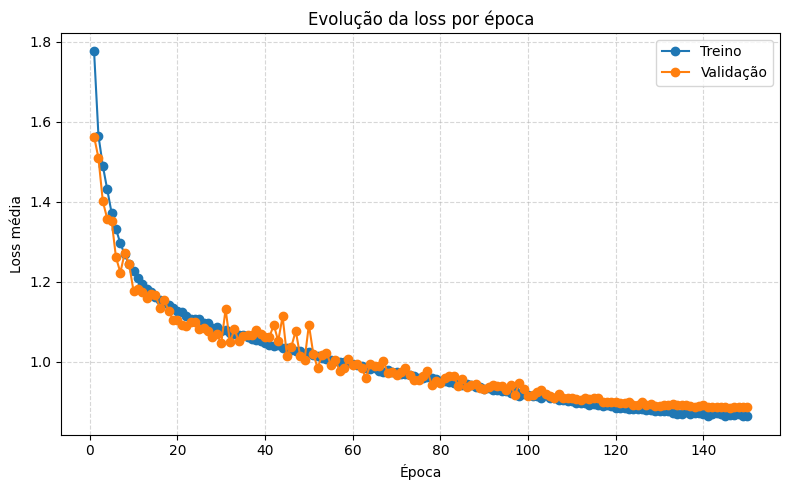

In [15]:
# Cria uma figura 8×5 para os gráficos.
plt.figure(figsize=(8, 5))

# Plota a curva da loss de treino ao longo das épocas (1..N), marcando os pontos.
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Treino', marker='o')

# Plota a curva da loss de validação ao longo das épocas, também com marcadores.
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validação', marker='o')

# Define o título do gráfico.
plt.title('Evolução da loss por época')

# Rotula o eixo X com “Época”.
plt.xlabel('Época')

# Rotula o eixo Y com “Loss média”.
plt.ylabel('Loss média')

# Adiciona uma grade discreta para facilitar a leitura.
plt.grid(True, linestyle='--', alpha=0.5)

# Exibe a legenda para distinguir as curvas.
plt.legend()

# Ajusta os espaçamentos para evitar cortes de textos/elementos.
plt.tight_layout()

# Renderiza o gráfico na saída.
plt.show()

### Avaliação final no conjunto de teste

Após o treinamento, avaliamos o modelo utilizando todos os exemplos de teste. Serão exibidos o relatório de classificação (precisão, recall e F1 por classe) e a matriz de confusão, que evidencia em um mapa de calor onde o modelo acerta ou confunde as classes.


Relatório de classificação (teste):
              precision    recall  f1-score   support

    airplane       0.78      0.83      0.80      1000
  automobile       0.87      0.88      0.87      1000
        bird       0.69      0.64      0.67      1000
         cat       0.55      0.54      0.55      1000
        deer       0.71      0.73      0.72      1000
         dog       0.66      0.66      0.66      1000
        frog       0.79      0.83      0.81      1000
       horse       0.81      0.80      0.81      1000
        ship       0.87      0.84      0.86      1000
       truck       0.84      0.83      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



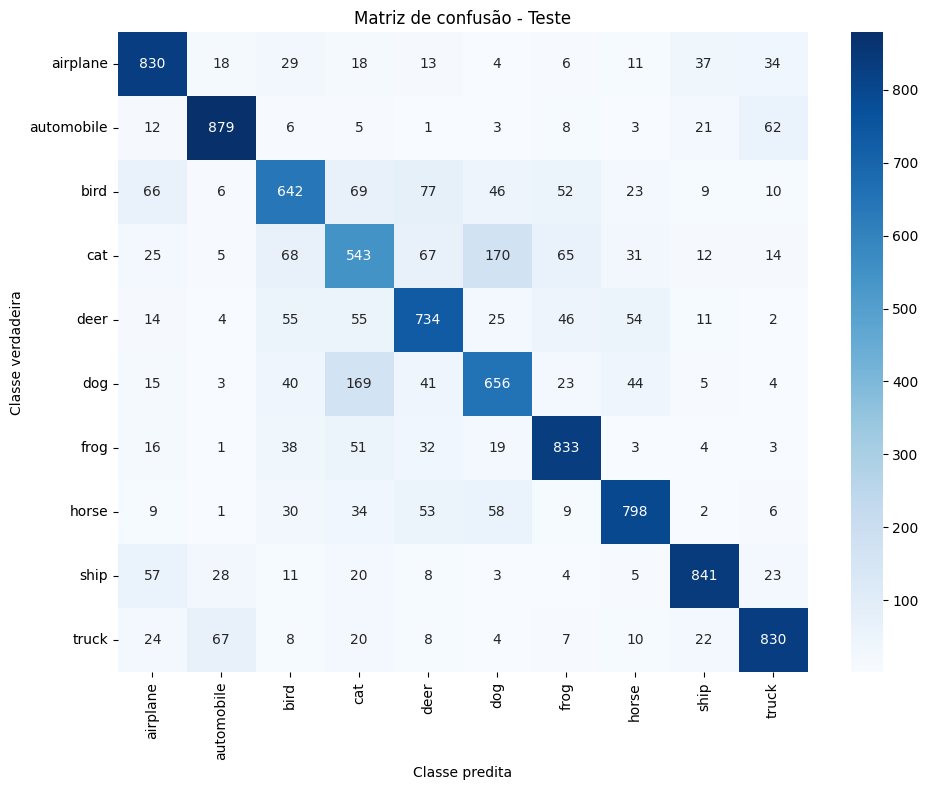

In [16]:
# Cabeçalho informativo desta seção (aviso do propósito do bloco).
# Gera métricas de classificação no conjunto de teste.

# Coloca a rede em modo de avaliação (desativa dropout e usa BN com estatísticas fixas).
net.eval()

# Inicializa listas para acumular previsões e rótulos de todos os lotes.
predicoes, alvos = [], []

# Desativa o cálculo de gradientes para acelerar a inferência e economizar memória.
with torch.no_grad():
    # Itera pelos lotes do loader de teste, recebendo imagens e rótulos verdadeiros.
    for imagens, rotulos in test_loader:
        # Move o batch de imagens para o dispositivo (CPU/GPU) configurado.
        imagens = imagens.to(args['device'])
        # Move os rótulos para o mesmo dispositivo.
        rotulos = rotulos.to(args['device'])
        # Forward: calcula os logits/saídas do modelo para o batch.
        saidas = net(imagens)
        # Converte logits em classes previstas (índice do maior logit por amostra).
        preds = saidas.argmax(dim=1)
        # Armazena as predições no CPU como NumPy para posterior concatenação.
        predicoes.append(preds.cpu().numpy())
        # Armazena os rótulos verdadeiros no CPU como NumPy.
        alvos.append(rotulos.cpu().numpy())

# Concatena todos os rótulos em um único vetor 1D (ordem dos lotes preservada).
y_true = np.concatenate(alvos)
# Concatena todas as predições em um único vetor 1D.
y_pred = np.concatenate(predicoes)
# Obtém os nomes de classe (CIFAR-10: airplane, automobile, …) do dataset de treino.
class_names = train_set.classes

# Imprime um cabeçalho textual para o relatório de classificação.
print('Relatório de classificação (teste):')
# Gera precisão/recall/F1 por classe; requer: from sklearn.metrics import classification_report.
print(classification_report(y_true, y_pred, target_names=class_names))

# Calcula a matriz de confusão (linhas = verdade, colunas = predito).
# Requer: from sklearn.metrics import confusion_matrix.
conf_mat = confusion_matrix(y_true, y_pred)

# Abre uma figura para o heatmap da matriz de confusão.
plt.figure(figsize=(10, 8))

# Plota a matriz de confusão como heatmap com rótulos nas bordas; requer: import seaborn as sns.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Define um título descritivo para o gráfico da matriz de confusão.
plt.title('Matriz de confusão - Teste')

# Rotula o eixo Y como “classe verdadeira”.
plt.ylabel('Classe verdadeira')

# Rotula o eixo X como “classe predita”.
plt.xlabel('Classe predita')

# Ajusta margens/espaçamentos para evitar cortes de textos.
plt.tight_layout()

# Renderiza o heatmap na saída.
plt.show()
